## PUMS Recoding

This notebook loads a PUMS person-level file (either for a given state or for the entire usa), extracts relevant variables, rebins them, and writes out a CSV file containing the recoded variables.

Place the input file in a `data` folder in the current directory.

The recoded data will be written to a file of the same name in the `data` folder, but with `_recoded` prior to the extension.

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd

from collections import Counter

from src import pdf, plots, coding_pums as CODING

### User Parameters

In [2]:
# where the input file is found
DATA_DIR = 'data'

# preprocessed PUMS file for entire USA
INPUT_FILE_NAME = 'pums_usa_2020.csv'

# whether to adjust income values to constant dollars before recoding
USE_CONSTANT_DOLLARS = True

# whether to drop rows with ages < 18
ADULTS_ONLY = True

# columns to extract from the data file
KEEP_COLS = [
    'ST',       # state identifier (also includes DC)
    'SERIALNO', # essentially the household ID
    'SPORDER',  # unique ID for each person within a given household
    'AGEP',     # numeric age, 0..99
    'PWGTP',    # person-level weight
    'ADJINC',   # income adustment factor
    'HISP',     # recoded detailed Hispanic origin (01 == not Spanish/Hispanic/Latino)
    'RAC1P',    # detailed race code
    'SCHL',     # educational attainment
    'HICOV',    # health insurance recode
    'PINCP',    # total person's income (use ADJINC to adjust to constant dollars)
    'SEX',      # sex (at birth, presumably)
]

#### Load the input file

In [3]:
INPUT_FILE = os.path.join(DATA_DIR, INPUT_FILE_NAME)
print('Loading file "{0}"...'.format(INPUT_FILE))
raw_df = pd.read_csv(INPUT_FILE)

if ADULTS_ONLY:
    raw_df = raw_df[raw_df['AGEP'] >= 18]
    raw_df = raw_df.reset_index(drop=True)

raw_df

Loading file "data/pums_usa_2020.csv"...


,ST,SERIALNO,SPORDER,AGEP,ADJINC,PWGTP,HISP,RAC1P,SCHL,HICOV,PINCP,SEX
0,1,2020HU0989848,1,79,1006149,32,1,1,22.0,1,151800.0,2
1,1,2020HU0723924,2,72,1006149,84,1,1,22.0,1,76900.0,2
2,1,2020HU0724020,1,26,1006149,72,1,1,20.0,1,23000.0,1
3,1,2020HU0724020,2,26,1006149,73,1,1,16.0,2,20000.0,1
4,1,2020HU0724093,1,21,1006149,102,1,3,19.0,1,2300.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2136799,56,2020HU0745188,2,41,1006149,193,2,1,19.0,2,60000.0,2
2136800,56,2020HU0745709,1,41,1006149,56,1,1,22.0,1,39000.0,2
2136801,56,2020HU0745709,2,40,1006149,52,1,1,20.0,1,48000.0,1
2136802,56,2020HU0745861,2,28,1006149,150,1,1,17.0,1,65000.0,1


In [4]:
# determine whether this is a file for a single state or the entire USA
unique_state_count = len(set(raw_df['ST'].values))
assert unique_state_count >= 1
assert unique_state_count <= 51 # DC is in the file also
single_state_file = 1 == unique_state_count

print('Single state file: {0}'.format(single_state_file))

if single_state_file:
    # check the number of unique people - should have a unique individual per row of the dataframe
    # (concat SERIALNO and SPORDER to make a unique identifier for each person)
    id_set = set()
    for index, row in raw_df.iterrows():
        # household/family ID
        serialno = row['SERIALNO']
        # person id within the household
        person = row['SPORDER']
        key = '{0}|{1}'.format(serialno, person)
        id_set.add(key)
    num_individuals = len(id_set)

    # should have a unique person on each line of the file
    assert num_individuals == raw_df.shape[0]

Single state file: False


#### Extract desired columns

In [5]:
recoded_df = raw_df[KEEP_COLS].copy()
recoded_df

,ST,SERIALNO,SPORDER,AGEP,PWGTP,ADJINC,HISP,RAC1P,SCHL,HICOV,PINCP,SEX
0,1,2020HU0989848,1,79,32,1006149,1,1,22.0,1,151800.0,2
1,1,2020HU0723924,2,72,84,1006149,1,1,22.0,1,76900.0,2
2,1,2020HU0724020,1,26,72,1006149,1,1,20.0,1,23000.0,1
3,1,2020HU0724020,2,26,73,1006149,1,1,16.0,2,20000.0,1
4,1,2020HU0724093,1,21,102,1006149,1,3,19.0,1,2300.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2136799,56,2020HU0745188,2,41,193,1006149,2,1,19.0,2,60000.0,2
2136800,56,2020HU0745709,1,41,56,1006149,1,1,22.0,1,39000.0,2
2136801,56,2020HU0745709,2,40,52,1006149,1,1,20.0,1,48000.0,1
2136802,56,2020HU0745861,2,28,150,1006149,1,1,17.0,1,65000.0,1


#### Drop all rows with missing entries for the SCHL field

Approx. 2.7% of the education values are missing.

In [6]:
recoded_df = recoded_df[recoded_df['SCHL'].notna()]
recoded_df

,ST,SERIALNO,SPORDER,AGEP,PWGTP,ADJINC,HISP,RAC1P,SCHL,HICOV,PINCP,SEX
0,1,2020HU0989848,1,79,32,1006149,1,1,22.0,1,151800.0,2
1,1,2020HU0723924,2,72,84,1006149,1,1,22.0,1,76900.0,2
2,1,2020HU0724020,1,26,72,1006149,1,1,20.0,1,23000.0,1
3,1,2020HU0724020,2,26,73,1006149,1,1,16.0,2,20000.0,1
4,1,2020HU0724093,1,21,102,1006149,1,3,19.0,1,2300.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2136799,56,2020HU0745188,2,41,193,1006149,2,1,19.0,2,60000.0,2
2136800,56,2020HU0745709,1,41,56,1006149,1,1,22.0,1,39000.0,2
2136801,56,2020HU0745709,2,40,52,1006149,1,1,20.0,1,48000.0,1
2136802,56,2020HU0745861,2,28,150,1006149,1,1,17.0,1,65000.0,1


## Recode Selected Variables

In [7]:
def sum_of_values(ctr):
    """
    Sum the values in the given instance of collections.Counter and return the total.
    """
    
    total = 0
    for k,v in ctr.items():
        total += v
    return total

In [8]:
# map of variable enumerator from the coding file to the name of that column
col_map = {}

#### Age

In [9]:
def recode_age(df):
    """
    Recode the PUMS AGEP field as follows:
    
    class Age(Enum):
        AGE_0_17    = 0  #  0-17 years old
        AGE_18_24   = 1  # 18-24 years old
        AGE_25_34   = 2  # 25-34 years old
        AGE_35_44   = 3  # 35-44 years old
        AGE_45_54   = 4  # 45-54 years old
        AGE_55_64   = 5  # 55-64 years old
        AGE_65_PLUS = 6  # 65 or older
    
    """
    
    age_values = df['AGEP'].values
    
    new_values = []
    for pums_age in age_values:
        # the PUMS age should be in the range [0,99]
        assert pums_age >= 0 and pums_age <= 99
        
        if pums_age >= 65:
            recoded = CODING.Age.AGE_65_PLUS.value
        elif pums_age >= 55:
            recoded = CODING.Age.AGE_55_64.value
        elif pums_age >= 45:
            recoded = CODING.Age.AGE_45_54.value
        elif pums_age >= 35:
            recoded = CODING.Age.AGE_35_44.value
        elif pums_age >= 25:
            recoded = CODING.Age.AGE_25_34.value
        elif pums_age >= 18:
            recoded = CODING.Age.AGE_18_24.value
        else:
            recoded = CODING.Age.AGE_0_17.value
            
        new_values.append(recoded)
        
    # drop the AGE1P column
    df = df.drop(columns=['AGEP'])
    # insert a new Age column
    df = df.assign(Age = new_values)
    
    ctr = Counter(df['Age'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.AGE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [10]:
recoded_df = recode_age(recoded_df)
col_map[CODING.Variables.AGE] = 'Age'

#### Race / Ethnicity

In [11]:
def recode_race_eth(df):
    """
    Recode the PUMS RAC1P and HISP fields as follows:
    
    class RaceEth(Enum):
        WHITE     = 0  # White alone
        BLACK     = 1  # Black or African American alone
        ASIAN     = 2  # Asian alone
        OTHER     = 3  # Other race, multiracial
        HISPANIC  = 4  # Hispanic

    """
    
    # map of PUMS RAC1P value to RaceEth value
    recode_map = {
        1 : CODING.RaceEth.WHITE.value, # white alone
        2 : CODING.RaceEth.BLACK.value, # black alone
        3 : CODING.RaceEth.OTHER.value, # American Indian alone
        4 : CODING.RaceEth.OTHER.value, # Alaska Native alone
        5 : CODING.RaceEth.OTHER.value, # American Indian and Alaska Native
        6 : CODING.RaceEth.ASIAN.value, # Asian alone
        7 : CODING.RaceEth.OTHER.value, # Native Hawaiian and other Pacific Islander alone
        8 : CODING.RaceEth.OTHER.value, # Some other single race
        9 : CODING.RaceEth.OTHER.value, # Two or more races
    }
    
    race_values = df['RAC1P'].values
    hisp_values = df['HISP'].values
    
    new_values = []
    for i, pums_race in enumerate(race_values):
        # pums RAC1P value >= 1 and <= 9
        assert pums_race >= 1 and pums_race <= 9
        
        # check if hispanic or not
        is_hispanic = 1 != hisp_values[i]
        
        if is_hispanic:
            recoded_race = CODING.RaceEth.HISPANIC.value
        else:
            assert pums_race in recode_map
            recoded_race = recode_map[pums_race]
                
        new_values.append(recoded_race)
        
    df = df.drop(columns=['RAC1P'])
    df = df.drop(columns=['HISP'])
    df = df.assign(RaceEth = new_values)
    
    ctr = Counter(df['RaceEth'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.RACE_ETH]
    assert df.shape[0] == sum_of_values(ctr)
    return df    

In [12]:
recoded_df = recode_race_eth(recoded_df)
col_map[CODING.Variables.RACE_ETH] = 'RaceEth'

#### Education

In [13]:
def recode_education(df):
    """
    Recode the PUMS SCHL field as follows:
    
    class Education(Enum):
        LT_HS           = 0  # None, preschool, kindergarten, grades 1-12
        HS_GRAD         = 1  # Regular high school diploma or GED
        SOME_COLLEGE    = 2  # Combine the next two
        DEG_ASSOC       = 3  # Associate's degree
        DEG_BACHELORS   = 4  # Bachelor's degree
        DEG_GRADUATE    = 5  # Master's, Ph.D., prof degree

    """
    
    # map of PUMS SCHL value to recoded value
    recode_map = {
        1    : CODING.Education.LT_HS.value,  # No schooling completed
        2    : CODING.Education.LT_HS.value,  # Nursery school, preschool
        3    : CODING.Education.LT_HS.value,  # Kindergarten
        4    : CODING.Education.LT_HS.value,  # Grade 1  
        5    : CODING.Education.LT_HS.value,  # Grade 2
        6    : CODING.Education.LT_HS.value,
        7    : CODING.Education.LT_HS.value,
        8    : CODING.Education.LT_HS.value,
        9    : CODING.Education.LT_HS.value,
        10   : CODING.Education.LT_HS.value,
        11   : CODING.Education.LT_HS.value,
        12   : CODING.Education.LT_HS.value,
        13   : CODING.Education.LT_HS.value,    # Grade 10
        14   : CODING.Education.LT_HS.value,    # Grade 11
        15   : CODING.Education.LT_HS.value,    # Grade 12, no diploma
        16   : CODING.Education.HS_GRAD.value,  # HS diploma
        17   : CODING.Education.HS_GRAD.value,  # GED
        18   : CODING.Education.SOME_COLLEGE.value,  # Less than one year of college
        19   : CODING.Education.SOME_COLLEGE.value,  # More than one year of college, no degree
        20   : CODING.Education.DEG_ASSOC.value,     
        21   : CODING.Education.DEG_BACHELORS.value,
        22   : CODING.Education.DEG_GRADUATE.value,  # Masters degree
        23   : CODING.Education.DEG_GRADUATE.value,  # Professional degree
        24   : CODING.Education.DEG_GRADUATE.value   # Doctoral degree
    }
    
    values = df['SCHL'].values
    
    new_values = []
    for pums_educ in values:
        assert pums_educ >= 1 and pums_educ <= 24
        # convert to int (Pandas set the column type to float because of NaNs)
        int_pums_educ = int(pums_educ)
        assert int_pums_educ in recode_map
        # do a lookup to get the recoded value
        recoded_educ = recode_map[int_pums_educ]
                
        new_values.append(recoded_educ)
                
    # drop the 'SCHL' column
    df = df.drop(columns=['SCHL'])
    # insert a new 'Education' column with the recoded values
    df = df.assign(Education = new_values)
    
    ctr = Counter(df['Education'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.EDUCATION]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [14]:
recoded_df = recode_education(recoded_df)
col_map[CODING.Variables.EDUCATION] = 'Education'

#### Insurance

In [15]:
def recode_insurance(df):
    """
    Recode the PUMS HICOV field as follows:
    
    class Insurance(Enum):
        YES = 0
        NO  = 1

    """
    
    values = df['HICOV'].values
    
    new_values = []
    for pums_ins in values:
        assert 1 == pums_ins or 2 == pums_ins
        # do a lookup to get the recoded value
        recoded_ins = CODING.INSURANCE_RECODE_MAP[pums_ins]
                
        new_values.append(recoded_ins)
        
    df = df.drop(columns=['HICOV'])
    df = df.assign(Insurance = new_values)
        
    ctr = Counter(df['Insurance'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.INSURANCE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [16]:
recoded_df = recode_insurance(recoded_df)
col_map[CODING.Variables.INSURANCE] = 'Insurance'

#### Income

In [17]:
def recode_income(df):
    """
    Recode the PUMS PINCP field as follows:
    
    class Income(Enum):
        INC_LT_25   = 0  # Less than $25K
        INC_25_50   = 1  # $25K to $49,999
        INC_50_100  = 2  # $50K to $99,999
        INC_GT_100  = 3  # $100K or more
        INC_MISSING = 4  # Missing 

    The values are optionally adjusted to constant dollars.
    """
    
    values = df['PINCP'].values
    adjustments = df['ADJINC'].values
    
    new_values = []
    for i,val in enumerate(values):
        if np.isnan(val):
            # missing
            recoded_inc = CODING.Income.INC_MISSING.value
        else:                
            # adjust for inflation to constant dollars, if desired
            adj_factor = 1.0
            if USE_CONSTANT_DOLLARS:
                adj_factor = adjustments[i] * 1.0e-6

            pums_income = val * adj_factor
            
            if pums_income < 25000.0:
                recoded_inc = CODING.Income.INC_LT_25.value
            elif pums_income >= 25000.0 and pums_income < 50000.0:
                recoded_inc = CODING.Income.INC_25_50.value
            elif pums_income >= 50000.0 and pums_income < 100000.0:
                recoded_inc = CODING.Income.INC_50_100.value
            else:
                recoded_inc = CODING.Income.INC_GT_100.value
                    
        new_values.append(recoded_inc)
        
    df = df.drop(columns=['PINCP', 'ADJINC'])
    df = df.assign(Income = new_values)
    
    ctr = Counter(df['Income'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.INCOME]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [18]:
recoded_df = recode_income(recoded_df)
col_map[CODING.Variables.INCOME] = 'Income'

#### SEX

In [19]:
def recode_sex(df):
    """
    Recode the PUMS SEX variable as follows:
    
    class Sex(Enum):
        MALE   = 0
        FEMALE = 1

    """
    
    values = df['SEX'].values
    
    new_values = []
    for pums_sex in values:
        assert 1 == pums_sex or 2 == pums_sex
        recoded_sex = CODING.SEX_RECODE_MAP[pums_sex]
            
        new_values.append(recoded_sex)

    df = df.drop(columns=['SEX'])
    df = df.assign(Sex = new_values)
    
    ctr = Counter(df['Sex'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.SEX]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [20]:
recoded_df = recode_sex(recoded_df)
col_map[CODING.Variables.SEX] = 'Sex'
recoded_df

,ST,SERIALNO,SPORDER,PWGTP,Age,RaceEth,Education,Insurance,Income,Sex
0,1,2020HU0989848,1,32,6,0,5,0,3,1
1,1,2020HU0723924,2,84,6,0,5,0,2,1
2,1,2020HU0724020,1,72,2,0,3,0,0,0
3,1,2020HU0724020,2,73,2,0,1,1,0,0
4,1,2020HU0724093,1,102,1,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2136799,56,2020HU0745188,2,193,3,4,2,1,2,1
2136800,56,2020HU0745709,1,56,3,0,5,0,1,1
2136801,56,2020HU0745709,2,52,3,0,3,0,1,0
2136802,56,2020HU0745861,2,150,2,0,1,0,2,0


#### Plot the weighted and unweighted PDF of each variable

In [21]:
weighted_pdfs = {}
unweighted_pdfs = {}

# invert the column map to map column names to their variable enumerator
inv_col_map = {v:k for k,v in col_map.items()}

# ignore these cols for plotting PDFs
NON_DATA_COLS = {'ST', 'SERIALNO', 'SPORDER', 'PWGTP'}

weights = recoded_df['PWGTP'].values

# compute weighted PDF for each variable
for col_name in recoded_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    samples = recoded_df[col_name].values
    enumvar = inv_col_map[col_name]
    num_bins = CODING.BIN_COUNTS[enumvar]
    
    # weighted
    pdf_w = pdf.to_pdf(num_bins, samples, weights)
    weighted_pdfs[col_name] = pdf_w
    
    # unweighted
    pdf_u = pdf.to_pdf(num_bins, samples)
    unweighted_pdfs[col_name] = pdf_u

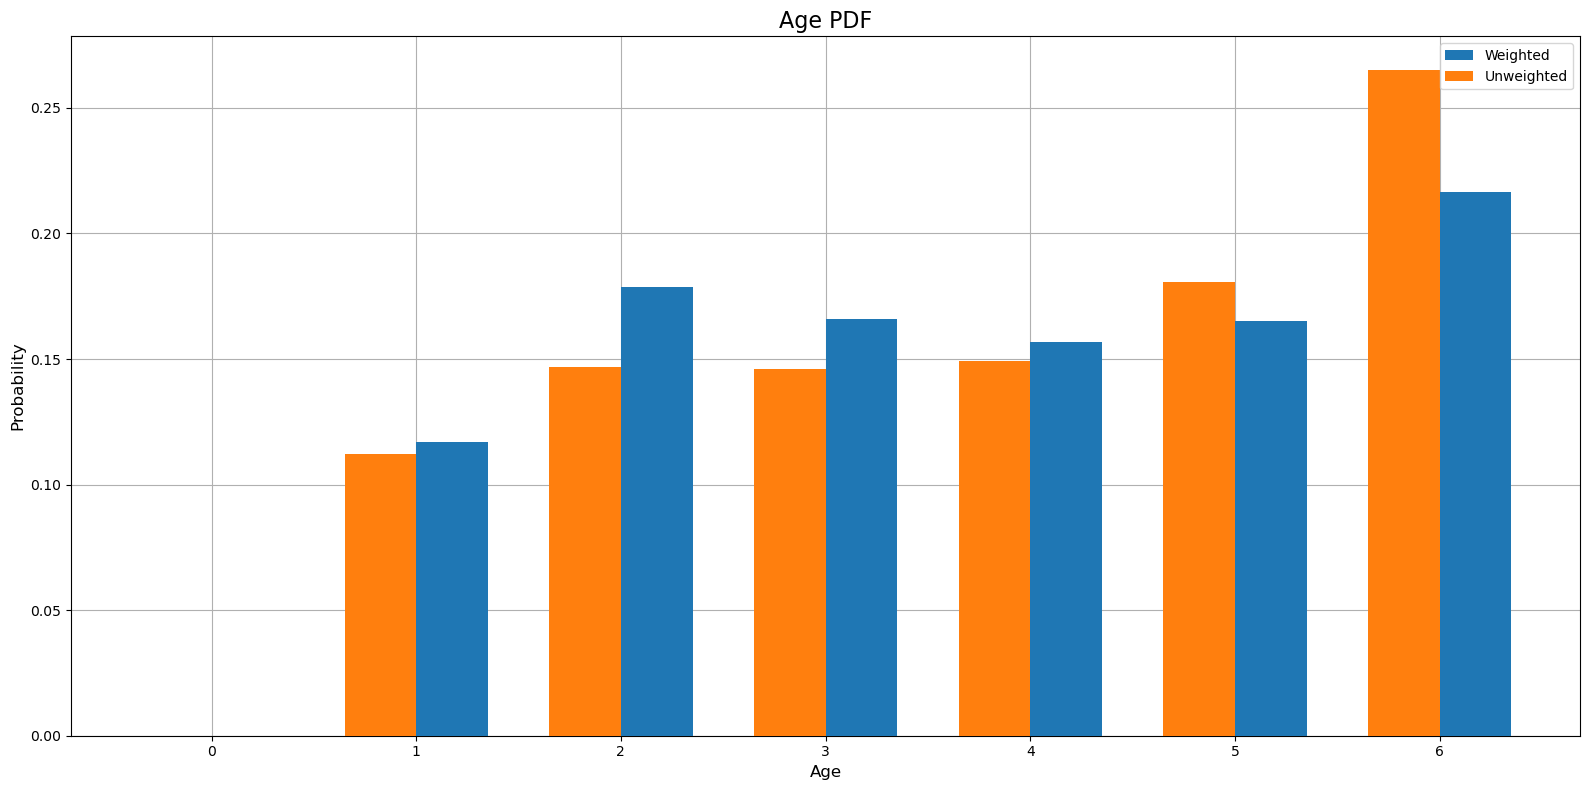

Unweighted PDF : [0.    0.112 0.147 0.146 0.149 0.181 0.265]
  Weighted PDF : [0.    0.117 0.179 0.166 0.157 0.165 0.217]


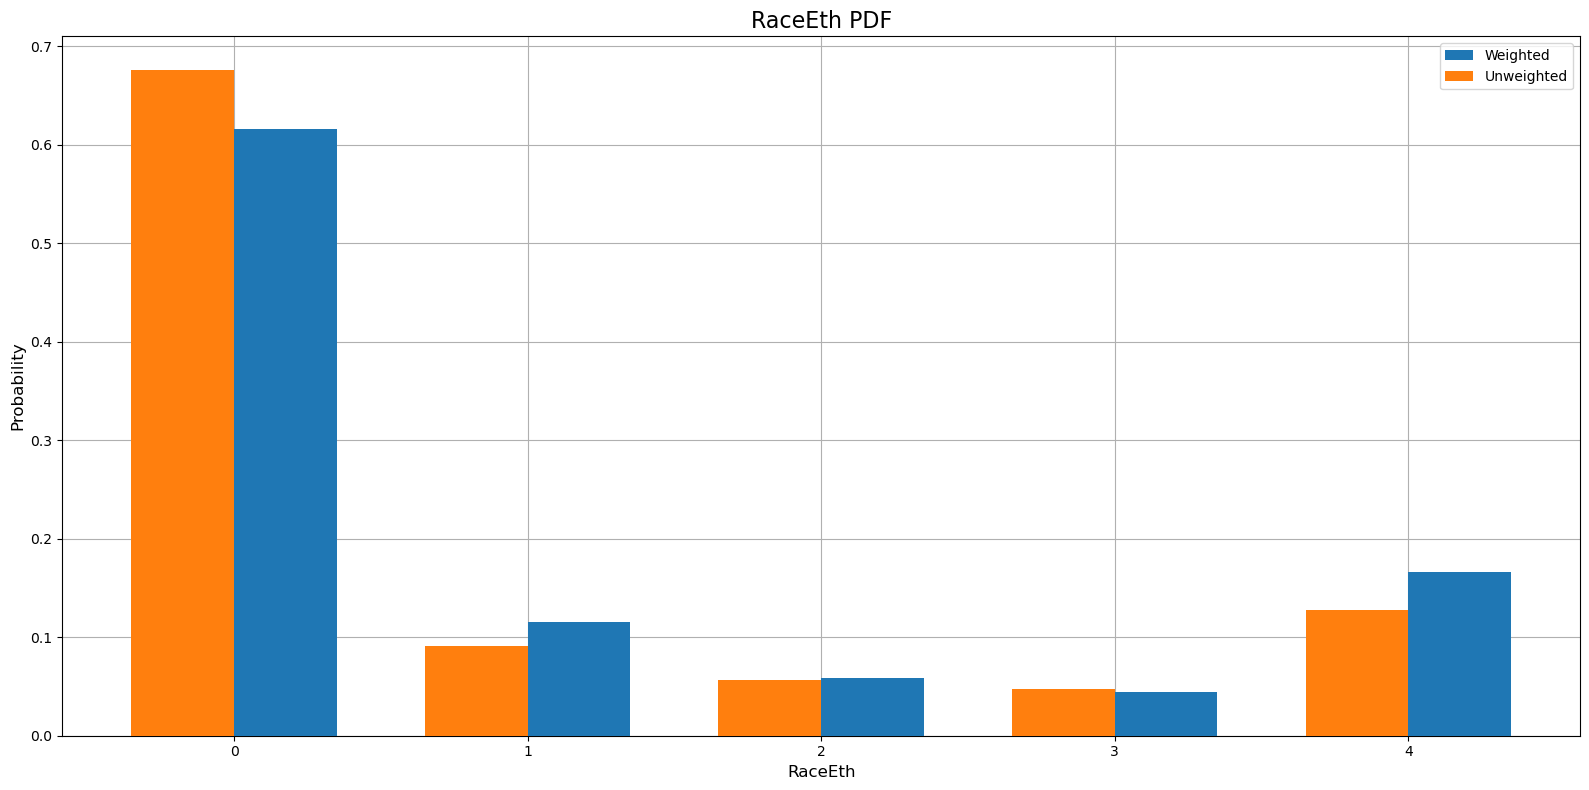

Unweighted PDF : [0.676 0.091 0.057 0.048 0.128]
  Weighted PDF : [0.616 0.116 0.058 0.044 0.166]


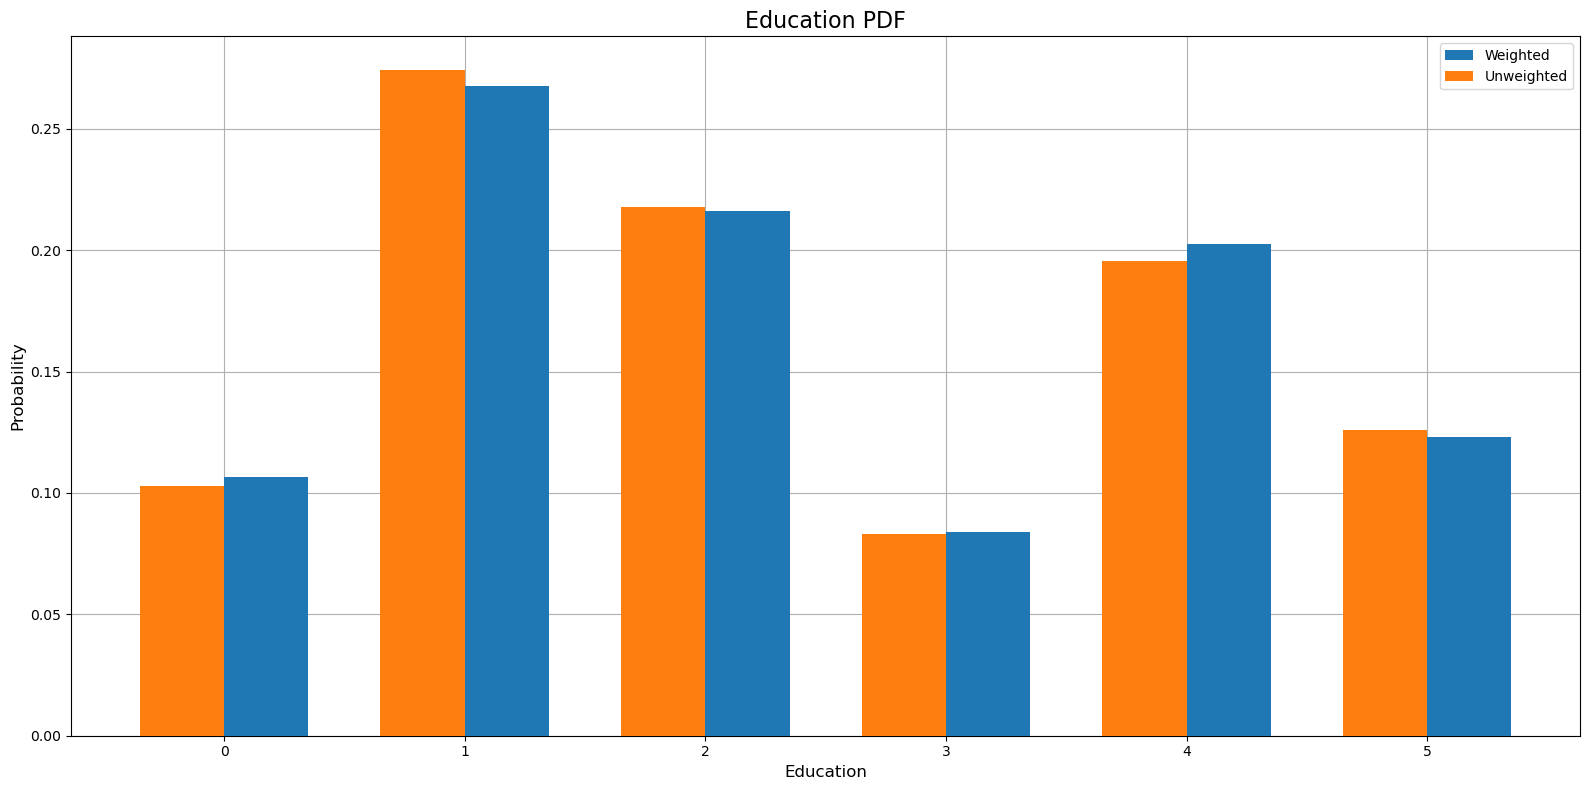

Unweighted PDF : [0.103 0.274 0.218 0.083 0.196 0.126]
  Weighted PDF : [0.107 0.268 0.216 0.084 0.203 0.123]


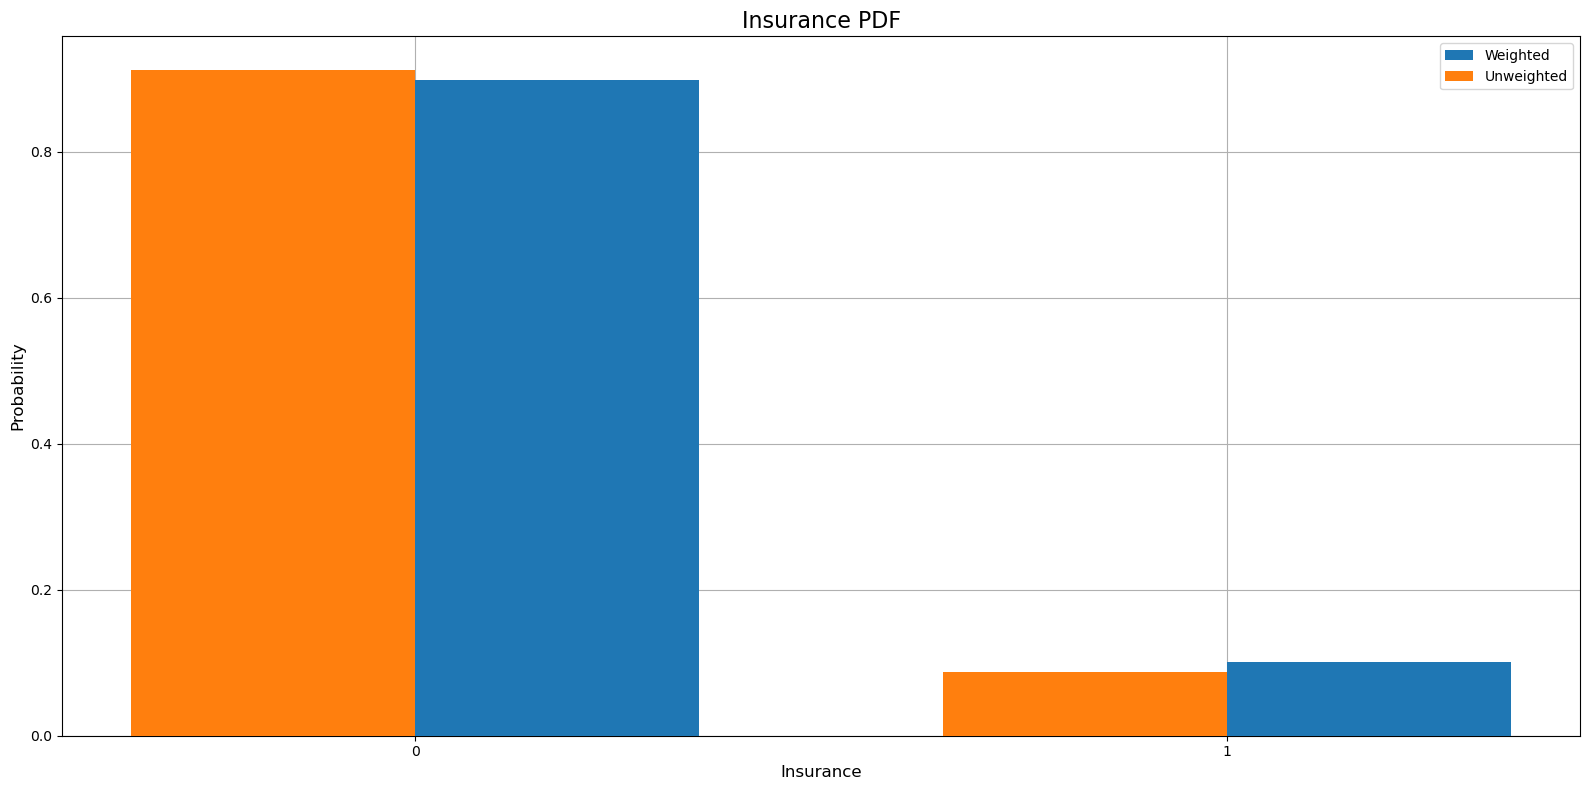

Unweighted PDF : [0.912 0.088]
  Weighted PDF : [0.898 0.102]


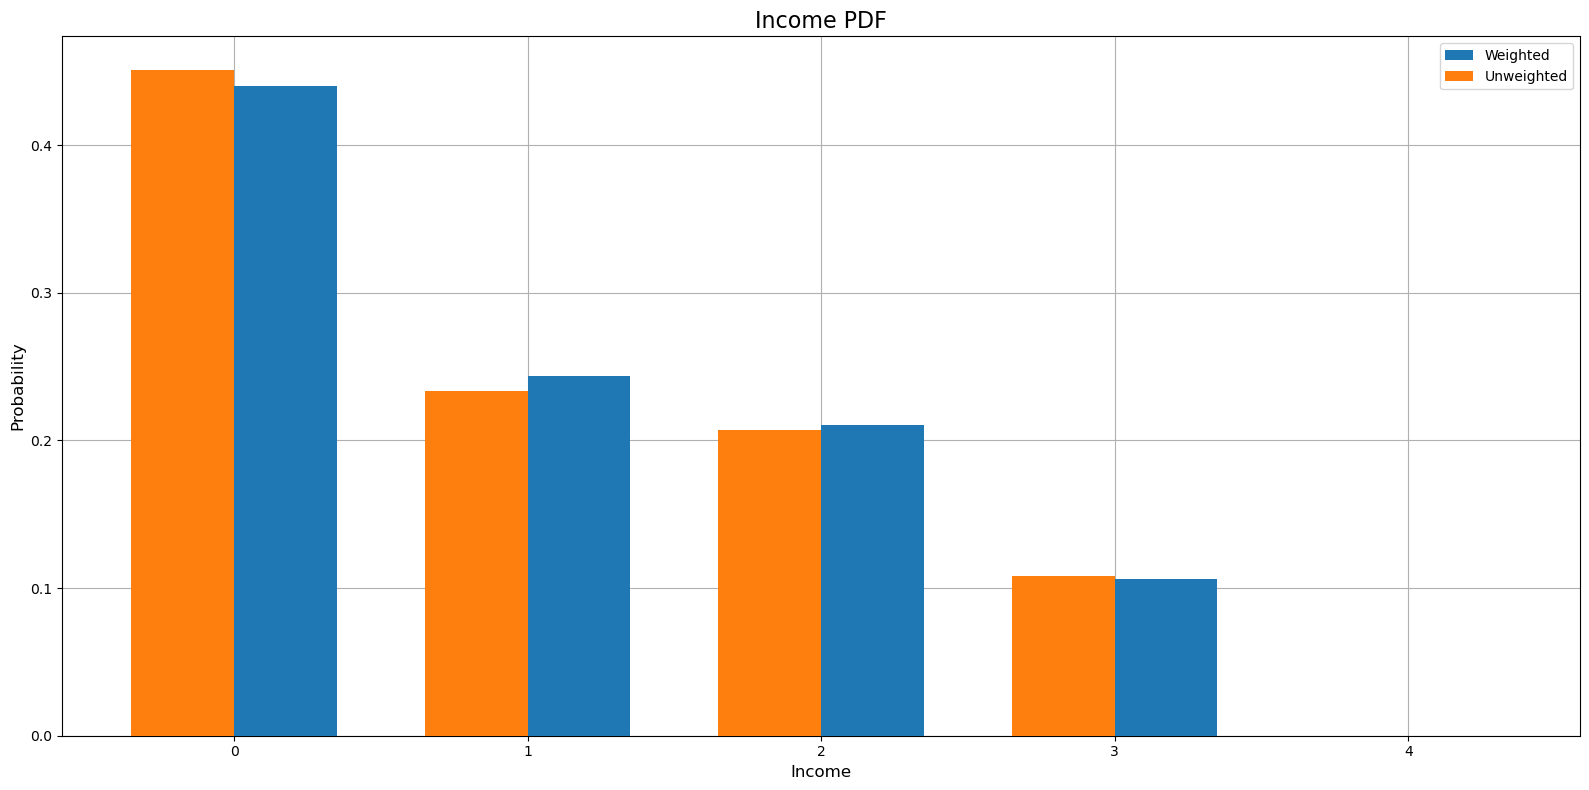

Unweighted PDF : [0.451 0.233 0.207 0.108 0.   ]
  Weighted PDF : [0.44  0.244 0.211 0.106 0.   ]


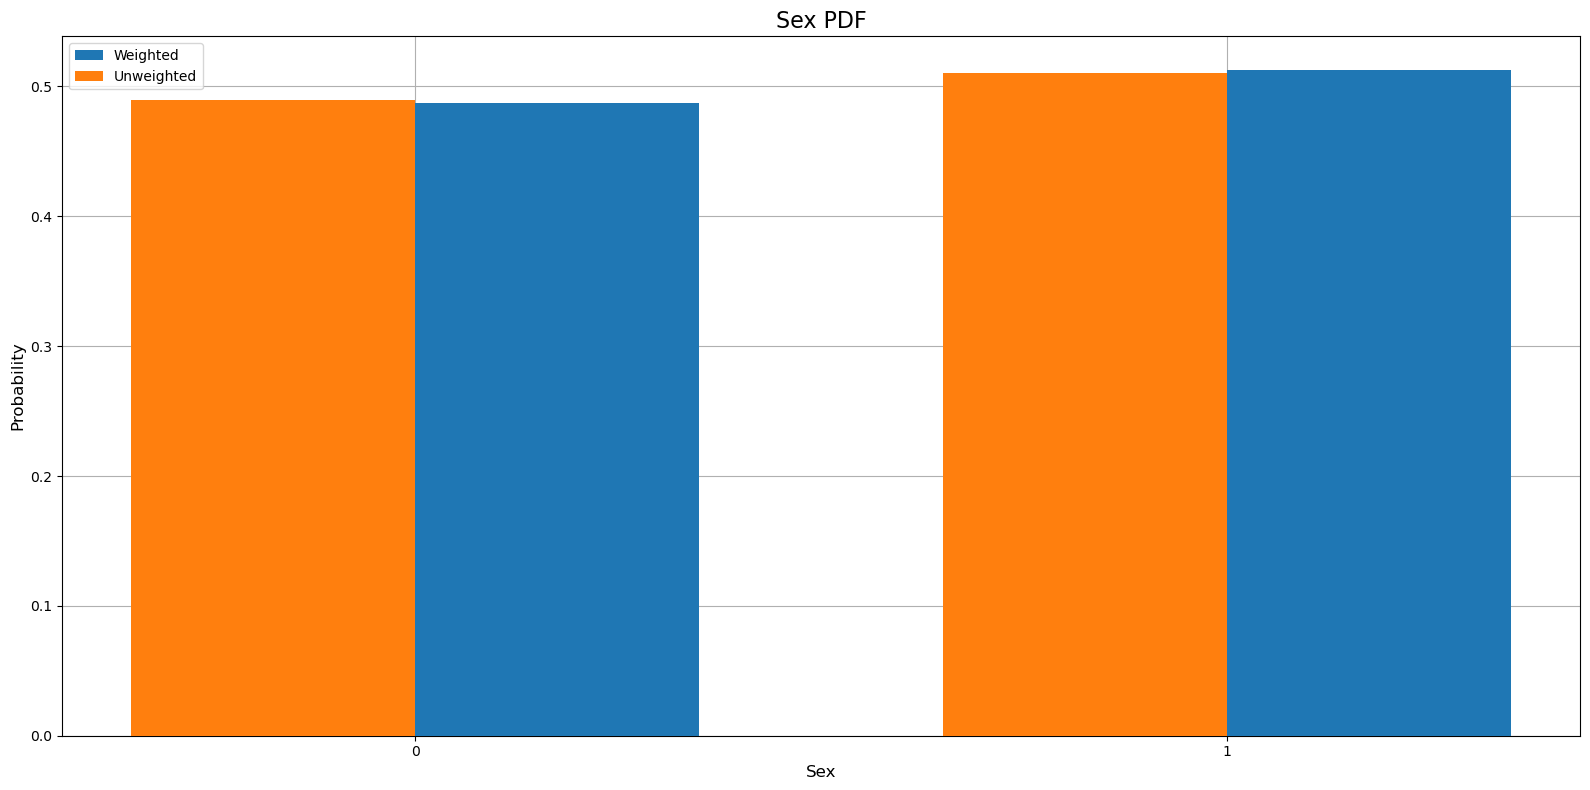

Unweighted PDF : [0.49 0.51]
  Weighted PDF : [0.487 0.513]


In [22]:
# display precision
P = 3

for col_name in recoded_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    plots.dual_histogram_from_pdfs(col_name, unweighted_pdfs[col_name], weighted_pdfs[col_name],
                                   labels=['Unweighted', 'Weighted'])
    
    print('Unweighted PDF : {0}'.format(np.array_str(unweighted_pdfs[col_name], precision=P)))
    print('  Weighted PDF : {0}'.format(np.array_str(weighted_pdfs[col_name],   precision=P)))

#### Write recoded PUMS data to disk

In [23]:
# write to disk
f,e = os.path.splitext(INPUT_FILE)
output_file = f + '_recoded' + e
recoded_df.to_csv(output_file, index=False)
print('Wrote file "{0}".'.format(output_file))

Wrote file "data/pums_usa_2020_recoded.csv".
